In [69]:
import pandas as pd
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Data Cleaning

In [36]:
# Downloaed from haarcascade github
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

In [34]:
#common function to crop face if 2 eyes are seen in the image
def get_cropped_image_if_2eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [27]:
import os

path_to_data ='./dataset/'
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [29]:
import shutil

path_to_cr_data = './dataset/cropped/'

if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [35]:
cropped_img_dirs = []
athlete_file_names_dict = {}

for img_dir in img_dirs:
    athlete_name = img_dir.split('/')[-1]
    cropped_folder = path_to_cr_data + athlete_name
    if not os.path.exists(cropped_folder):
        os.mkdir(cropped_folder)
        cropped_img_dirs.append(cropped_folder)
    
    count = 1
    athlete_file_names_dict[athlete_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2eyes(entry.path)
        if roi_color is not None:
            cropped_file_name = athlete_name + str(count) +".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            athlete_file_names_dict[athlete_name].append(cropped_file_path)
            count += 1

In [49]:
athlete_file_names_dict = {}
for img_dir in cropped_img_dirs:
    athlete_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    athlete_file_names_dict[athlete_name] = file_list

## Feature Engineering

In [83]:
import pywt

def w2d(img, mode="haar", level=1):
    imArray = img
    #Datatype conversions
    
    #convert to grayscale
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    
    #convert to float
    imArray = np.float32(imArray)
    imArray /= 255;
    #compute coefficients
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    
    #Process coefficients
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0;
    
    #Reconstruction
    imArray_H = pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

In [51]:
#pair names to int
class_dict = {}
count = 0

for athlete_name in athlete_file_names_dict.keys():
    class_dict[athlete_name] = count
    count += 1

In [52]:
X = []
y = []

for athlete_name, training_files in athlete_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
            
        scaled_raw_img = cv2.resize(img, (32,32))
        img_har = w2d(img,'db1',5)
        scaled_img_har = cv2.resize(img_har, (32,32))
        
        #vertically stack both image
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1), scaled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[athlete_name])

In [53]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(162, 4096)

## Model Training

We will use SVM with rbf kernel tuned with hueristic finetuning

In [54]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [57]:
#create sklearn pipeline
pipe = Pipeline([('scaler',StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))]) # randomly chosen parameters
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8536585365853658

In [58]:
len(X_test)

41

In [60]:
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [59]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       1.00      0.91      0.95        11
           2       0.67      1.00      0.80         4
           3       1.00      0.83      0.91         6
           4       0.85      0.85      0.85        13

    accuracy                           0.85        41
   macro avg       0.85      0.86      0.84        41
weighted avg       0.87      0.85      0.86        41



### Use GridSearchCV to try out different models with different parameters

In [62]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [66]:
model_params ={
    'svm':{
        'model': svm.SVC(gamma='auto', probability=True),
        'params': {
            'svc__C': [1,10,100,1000],
            'svc__kernel':['rbf','linear']}
    },
    
    'random_forest':{
        'model': RandomForestClassifier(),
        'params': {'randomforestclassifier__n_estimators': [1,5,10]}
    },
    
    'logistic_regression':{
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {'logisticregression__C':[1,5,10]}
    }
}

In [72]:
scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model']) #scale the data
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,svm,0.851333,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.595000,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.867667,{'logisticregression__C': 10}


In [73]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=10, gamma='auto', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=10, solver='liblinear'))])}

In [74]:
best_estimators['logistic_regression']

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=10, solver='liblinear'))])

In [75]:
print("Logistic Regression:", best_estimators['logistic_regression'].score(X_test, y_test))
print("SVM:", best_estimators['svm'].score(X_test, y_test))

Logistic Regression: 0.926829268292683
SVM: 0.8536585365853658


In [76]:
best_clf = best_estimators['logistic_regression']

Text(95.72222222222221, 0.5, 'True Value')

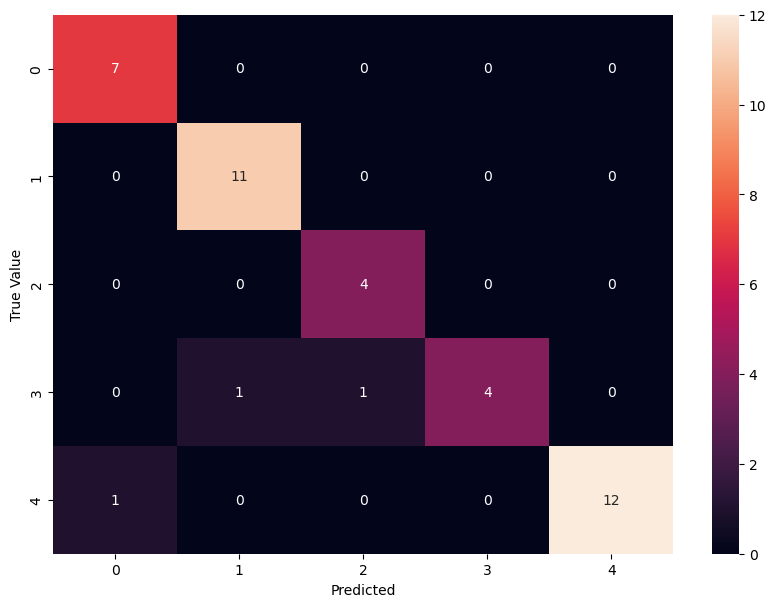

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, best_clf.predict(X_test))
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True Value')

### Save the trained model

In [78]:
import joblib

In [79]:
# save the model as a pickle in a file
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

### Save class dictionary

In [80]:
import json

In [82]:
with open('class_dictionary.json','w') as f:
    f.write(json.dump(class_dict))